In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

# Kalman Filter Implementation for Constant Acceleration Model (CA) in Python

Multisensor Data Fusion with acceleration ($\ddot x$ and $\ddot y$) and position ($x$ and $y$).

`CC-BY-SA2.0 Lizenz Paul Balzer, Motorblog http://www.cbcity.de`

![Kalman Filter](Kalman-Filter-Step.png)

First, we have to initialize the matrices and vectors. Setting up the math.

## State Vector

Constant Acceleration Model for Ego Motion in Plane

$$x_k= \left[ \begin{matrix} x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y \end{matrix} \right]$$

## Motion

Formal Definition:

$$x_{k+1} = A \cdot x_{k} + B \cdot u$$

Hence, we have no control input $u$:

$$x_{k+1} = \begin{bmatrix}1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 & 0 \\ 0 & 1 & 0 & \Delta t & 0 & \frac{1}{2}\Delta t^2 \\ 0 & 0 & 1 & 0 & \Delta t & 0 \\ 0 & 0 & 0 & 1 & 0 & \Delta t \\ 0 & 0 & 0 & 0 & 1 & 0  \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix} \cdot \begin{bmatrix} x \\ y \\ \dot x \\ \dot y \\ \ddot x \\ \ddot y\end{bmatrix}_{k}$$

### Measurement

$$y = H \cdot x$$

Acceleration ($\ddot x$ & $\ddot y$) as well as position ($x$ & $y$) is measured.

$$y = \begin{bmatrix}1 & 0 & 0 & 0 & 0 & 0 \\0 & 1 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 1\end{bmatrix} \cdot x$$

## Setting up the math

#### Initial State

In [7]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)
n=x.size # States
#plt.scatter(float(x[0]),float(x[1]), s=100)
#plt.title('Initial Location')

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]] (6, 1)


#### Initial Uncertainty

In [8]:
P = np.diag([100.0, 100.0, 10.0, 10.0, 1.0, 1.0])
print(P, P.shape)

[[100.   0.   0.   0.   0.   0.]
 [  0. 100.   0.   0.   0.   0.]
 [  0.   0.  10.   0.   0.   0.]
 [  0.   0.   0.  10.   0.   0.]
 [  0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   1.]] (6, 6)


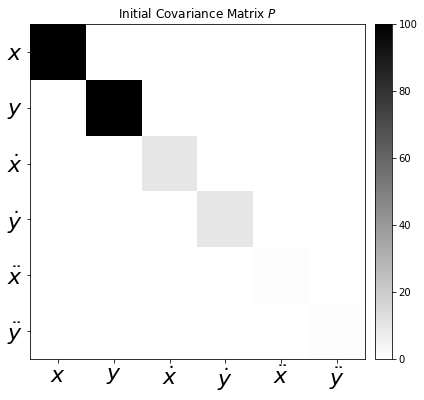

In [9]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Dynamic Matrix

It is calculated from the dynamics of the Egomotion.

$$x_{k+1} = x_{k} + \dot x_{k} \cdot \Delta t +  \ddot x_k \cdot \frac{1}{2}\Delta t^2$$
$$y_{k+1} = y_{k} + \dot y_{k} \cdot \Delta t +  \ddot y_k \cdot \frac{1}{2}\Delta t^2$$

$$\dot x_{k+1} = \dot x_{k} + \ddot x \cdot \Delta t$$
$$\dot y_{k+1} = \dot y_{k} + \ddot y \cdot \Delta t$$

$$\ddot x_{k+1} = \ddot x_{k}$$
$$\ddot y_{k+1} = \ddot y_{k}$$

In [10]:
dt = 0.1 # Time Step between Filter Steps

A = np.matrix([[1.0, 0.0, dt, 0.0, 1/2.0*dt**2, 0.0],
              [0.0, 1.0, 0.0, dt, 0.0, 1/2.0*dt**2],
              [0.0, 0.0, 1.0, 0.0, dt, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[1.    0.    0.1   0.    0.005 0.   ]
 [0.    1.    0.    0.1   0.    0.005]
 [0.    0.    1.    0.    0.1   0.   ]
 [0.    0.    0.    1.    0.    0.1  ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]] (6, 6)


## Measurement Matrix $H$

Here you can determine, which of the states is covered by a measurement. In this example, the position ($x$ and $y$) as well as the acceleration is measured ($\ddot x$ and $\ddot y$).

In [11]:
H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (4, 6)


## Measurement Noise Covariance $R$

In [12]:
ra = 10.0**2   # Noise of Acceleration Measurement
rp = 100.0**2  # Noise of Position Measurement
R = np.matrix([[rp, 0.0, 0.0, 0.0],
               [0.0, rp, 0.0, 0.0],
               [0.0, 0.0, ra, 0.0],
               [0.0, 0.0, 0.0, ra]])
print(R, R.shape)

[[10000.     0.     0.     0.]
 [    0. 10000.     0.     0.]
 [    0.     0.   100.     0.]
 [    0.     0.     0.   100.]] (4, 4)


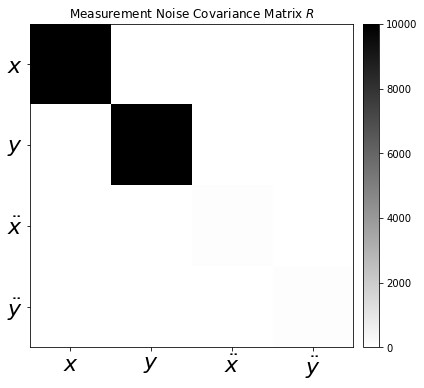

In [13]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(R, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Measurement Noise Covariance Matrix $R$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(5))
# set the locations and labels of the yticks
plt.yticks(np.arange(4),('$x$', '$y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(5))
# set the locations and labels of the yticks
plt.xticks(np.arange(4),('$x$', '$y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

The Position of an object can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

$$Q = \begin{bmatrix}
    \sigma_{x}^2 & 0 & \sigma_{x \dot x} & 0 & \sigma_{x \ddot x} & 0 \\
    0 & \sigma_{y}^2 & 0 & \sigma_{y \dot y} & 0 & \sigma_{y \ddot y} \\
    \sigma_{\dot x x} & 0 & \sigma_{\dot x}^2 & 0 & \sigma_{\dot x \ddot x} & 0 \\
    0 & \sigma_{\dot y y} & 0 & \sigma_{\dot y}^2 & 0 & \sigma_{\dot y \ddot y} \\
    \sigma_{\ddot x x} & 0 & \sigma_{\ddot x \dot x} & 0 & \sigma_{\ddot x}^2 & 0 \\
    0 & \sigma_{\ddot y y} & 0 & \sigma_{\ddot y \dot y} & 0 & \sigma_{\ddot y}^2
   \end{bmatrix} \cdot \sigma_{j}$$

To easily calcualte Q, one can ask the question: How the noise effects my state vector? For example, how the jerk change the position over one timestep dt. With $\sigma_{j}$ as the magnitude of the standard deviation of the jerk, which distrubs the car. We do not assume cross correlation, which means if a jerk will act in x direction of the movement, it will not push in y direction at the same time.

We can construct the values with the help of a matrix $G$, which is an "actor" to the state vector.

In [14]:
from sympy import Symbol, Matrix
from sympy.interactive import printing
printing.init_printing(use_latex=True)
dts = Symbol('\Delta t')

In [15]:
Gs = Matrix([dts**3/6, dts**2/2, dts])
Gs

⎡        3⎤
⎢\Delta t ⎥
⎢─────────⎥
⎢    6    ⎥
⎢         ⎥
⎢        2⎥
⎢\Delta t ⎥
⎢─────────⎥
⎢    2    ⎥
⎢         ⎥
⎣\Delta t ⎦

In [16]:
Gs*Gs.T

⎡        6          5          4⎤
⎢\Delta t   \Delta t   \Delta t ⎥
⎢─────────  ─────────  ─────────⎥
⎢    36         12         6    ⎥
⎢                               ⎥
⎢        5          4          3⎥
⎢\Delta t   \Delta t   \Delta t ⎥
⎢─────────  ─────────  ─────────⎥
⎢    12         4          2    ⎥
⎢                               ⎥
⎢        4          3           ⎥
⎢\Delta t   \Delta t           2⎥
⎢─────────  ─────────  \Delta t ⎥
⎣    6          2               ⎦

In [17]:
sj = 0.1

Q = np.matrix([[(dt**6)/36, 0, (dt**5)/12, 0, (dt**4)/6, 0],
               [0, (dt**6)/36, 0, (dt**5)/12, 0, (dt**4)/6],
               [(dt**5)/12, 0, (dt**4)/4, 0, (dt**3)/2, 0],
               [0, (dt**5)/12, 0, (dt**4)/4, 0, (dt**3)/2],
               [(dt**4)/6, 0, (dt**3)/2, 0, (dt**2),0],
               [0, (dt**4)/6, 0, (dt**3)/2, 0, (dt**2)]]) *sj**2

print(Q, Q.shape)

[[2.77777778e-10 0.00000000e+00 8.33333333e-09 0.00000000e+00
  1.66666667e-07 0.00000000e+00]
 [0.00000000e+00 2.77777778e-10 0.00000000e+00 8.33333333e-09
  0.00000000e+00 1.66666667e-07]
 [8.33333333e-09 0.00000000e+00 2.50000000e-07 0.00000000e+00
  5.00000000e-06 0.00000000e+00]
 [0.00000000e+00 8.33333333e-09 0.00000000e+00 2.50000000e-07
  0.00000000e+00 5.00000000e-06]
 [1.66666667e-07 0.00000000e+00 5.00000000e-06 0.00000000e+00
  1.00000000e-04 0.00000000e+00]
 [0.00000000e+00 1.66666667e-07 0.00000000e+00 5.00000000e-06
  0.00000000e+00 1.00000000e-04]] (6, 6)


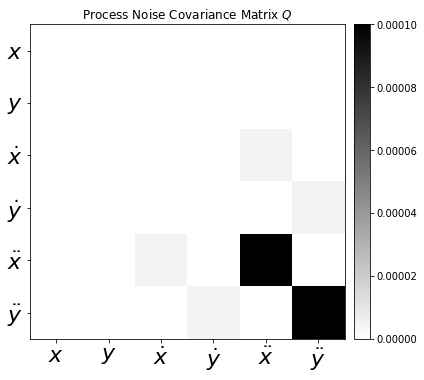

In [18]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $Q$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

## Identity Matrix $I$

In [19]:
I = np.eye(n)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (6, 6)


## Measurements

Typical update rates:

* Acceleration from IMU with `10Hz`
* Position from GPS with `1Hz`

Which means, that every 10th of an acceleration measurement, there is a new position measurement from GPS. The Kalman Filter can perfectly handle this unsynchronous measurement incoming.

### Positions

In [20]:
m = 500 # Measurements

sp= 1.0 # Sigma for position
px= 0.0 # x Position
py= 0.0 # y Position

mpx = np.array(px+sp*np.random.randn(m))
mpy = np.array(py+sp*np.random.randn(m))

# Generate GPS Trigger
GPS=np.ndarray(m,dtype='bool')
GPS[0]=True
# Less new position updates
for i in range(1,m):
    if i%10==0:
        GPS[i]=True
    else:
        mpx[i]=mpx[i-1]
        mpy[i]=mpy[i-1]
        GPS[i]=False

### Accelerations

In [21]:
# Acceleration
sa= 0.1 # Sigma for acceleration
ax= 0.0 # in X
ay= 0.0 # in Y

mx = np.array(ax+sa*np.random.randn(m))
my = np.array(ay+sa*np.random.randn(m))

In [22]:
measurements = np.vstack((mpx,mpy,mx,my))
print(measurements.shape)

(4, 500)


In [23]:
def plot_m():
    fig = plt.figure(figsize=(16,9))
    plt.subplot(211)
    plt.step(range(m),mpx, label='$x$')
    plt.step(range(m),mpy, label='$y$')
    plt.ylabel(r'Position $m$')
    plt.title('Measurements')
    plt.ylim([-10, 10])
    plt.legend(loc='best',prop={'size':18})

    plt.subplot(212)
    plt.step(range(m),mx, label='$a_x$')
    plt.step(range(m),my, label='$a_y$')
    plt.ylabel(r'Acceleration $m/s^2$')
    plt.ylim([-1, 1])
    plt.legend(loc='best',prop={'size':18})

    plt.savefig('Kalman-Filter-CA-Measurements.png', dpi=72, transparent=True, bbox_inches='tight')

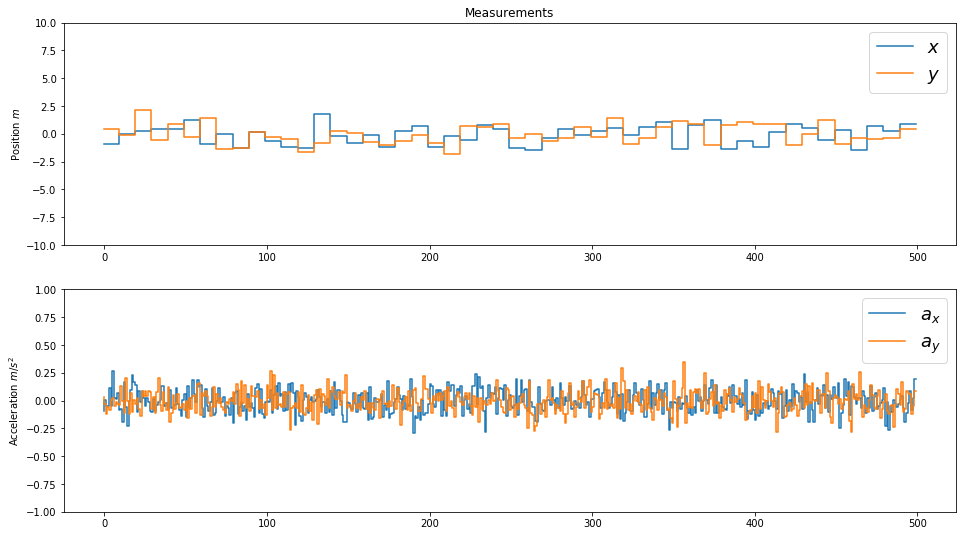

In [24]:
plot_m()

In [25]:
# Preallocation for Plotting
xt = []
yt = []
dxt= []
dyt= []
ddxt=[]
ddyt=[]
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kddy=[]


def savestates(x, Z, P, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    ddxt.append(float(x[4]))
    ddyt.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pddy.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kddy.append(float(K[5,0]))

## Kalman Filter

![Kalman Filter](https://raw.github.com/balzer82/Kalman/master/Kalman-Filter-Step.png)

In [26]:
for filterstep in range(m):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # if there is a GPS Measurement
    if GPS[filterstep]:
        # Compute the Kalman Gain
        S = H*P*H.T + R
        K = (P*H.T) * np.linalg.pinv(S)
    
        
        # Update the estimate via z
        Z = measurements[:,filterstep].reshape(H.shape[0],1)
        y = Z - (H*x)                            # Innovation or Residual
        x = x + (K*y)
        
        # Update the error covariance
        P = (I - (K*H))*P

   
    
    # Save states for Plotting
    savestates(x, Z, P, K)

Thats it.

![Job done](http://www.troll.me/images/the-chuck-norris/job-done.jpg)

# Let's take a look at the filter performance

### Uncertainty $P$

In [27]:
def plot_P():
    fig = plt.figure(figsize=(16,9))
    plt.subplot(211)
    plt.plot(range(len(measurements[0])),Px, label='$x$')
    plt.plot(range(len(measurements[0])),Py, label='$y$')
    plt.title('Uncertainty (Elements from Matrix $P$)')
    plt.legend(loc='best',prop={'size':22})
    plt.subplot(212)
    plt.plot(range(len(measurements[0])),Pddx, label='$\ddot x$')
    plt.plot(range(len(measurements[0])),Pddy, label='$\ddot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.legend(loc='best',prop={'size':22})

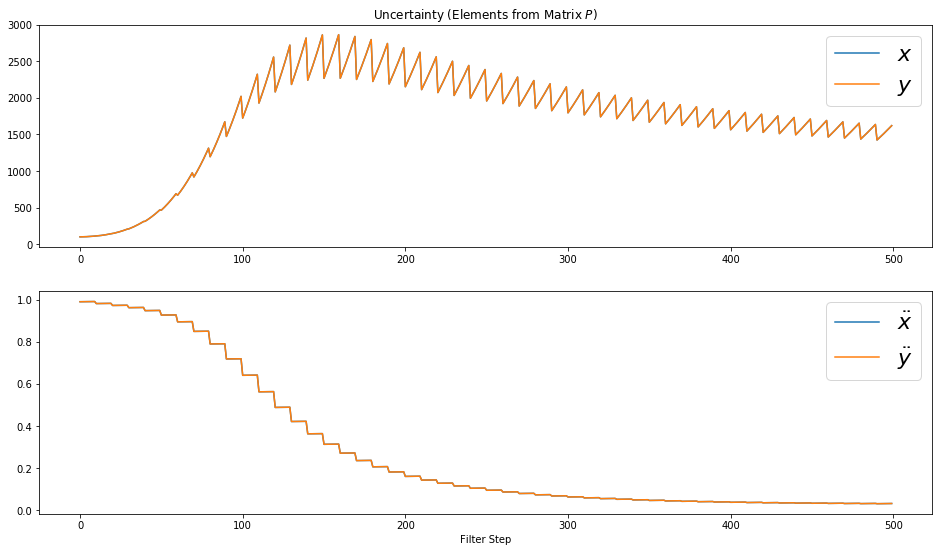

In [28]:
plot_P()

### Covariance Matrix

In [29]:
def plot_P2():
    fig = plt.figure(figsize=(6, 6))
    im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
    plt.title('Covariance Matrix $P$ (after %i Filter Steps)' % (m))
    ylocs, ylabels = plt.yticks()
    # set the locations of the yticks
    plt.yticks(np.arange(7))
    # set the locations and labels of the yticks
    plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

    xlocs, xlabels = plt.xticks()
    # set the locations of the yticks
    plt.xticks(np.arange(7))
    # set the locations and labels of the yticks
    plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$', '$\ddot x$', '$\ddot y$'), fontsize=22)

    plt.xlim([-0.5,5.5])
    plt.ylim([5.5, -0.5])

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="3%")
    plt.colorbar(im, cax=cax)


    plt.tight_layout()
    plt.savefig('Kalman-Filter-CA-CovarianceMatrix.png', dpi=72, transparent=True, bbox_inches='tight')

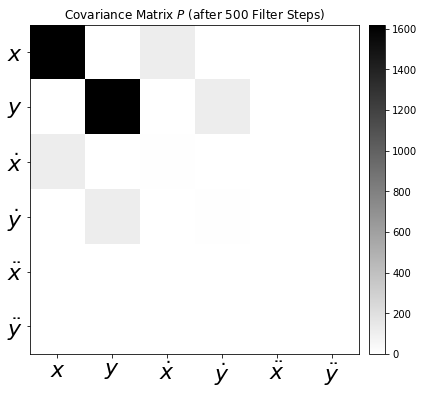

In [30]:
plot_P2()

### Kalman Gains

In [31]:
def plot_K():
    fig = plt.figure(figsize=(16,9))
    plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Kalman Gain for $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Kalman Gain for $\dot y$')
    plt.plot(range(len(measurements[0])),Kddx, label='Kalman Gain for $\ddot x$')
    plt.plot(range(len(measurements[0])),Kddy, label='Kalman Gain for $\ddot y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
    plt.legend(loc='best',prop={'size':18})

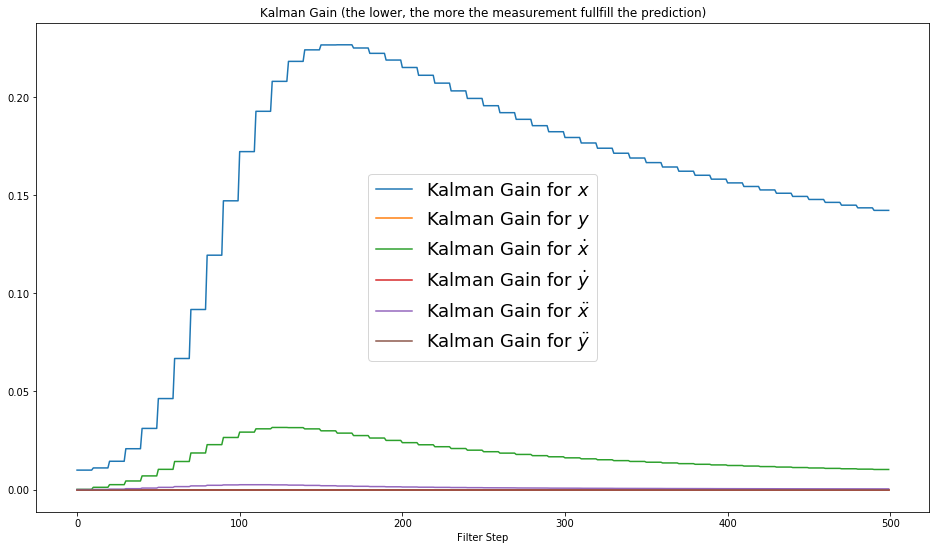

In [32]:
plot_K()

## State Vector

In [33]:
def plot_x():
    
    fig = plt.figure(figsize=(16,16))

    plt.subplot(311)
    plt.step(range(len(measurements[0])),ddxt, label='$\ddot x$')
    plt.step(range(len(measurements[0])),ddyt, label='$\ddot y$')

    plt.title('Estimate (Elements from State Vector $x$)')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel(r'Acceleration $m/s^2$')
    plt.ylim([-.1,.1])

    plt.subplot(312)
    plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
    plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

    plt.ylabel('')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel(r'Velocity $m/s$')
    plt.ylim([-1,1])

    plt.subplot(313)
    plt.step(range(len(measurements[0])),xt, label='$x$')
    plt.step(range(len(measurements[0])),yt, label='$y$')

    plt.xlabel('Filter Step')
    plt.ylabel('')
    plt.legend(loc='best',prop={'size':22})
    plt.ylabel(r'Position $m$')
    plt.ylim([-1,1])

    plt.savefig('Kalman-Filter-CA-StateEstimated.png', dpi=72, transparent=True, bbox_inches='tight')

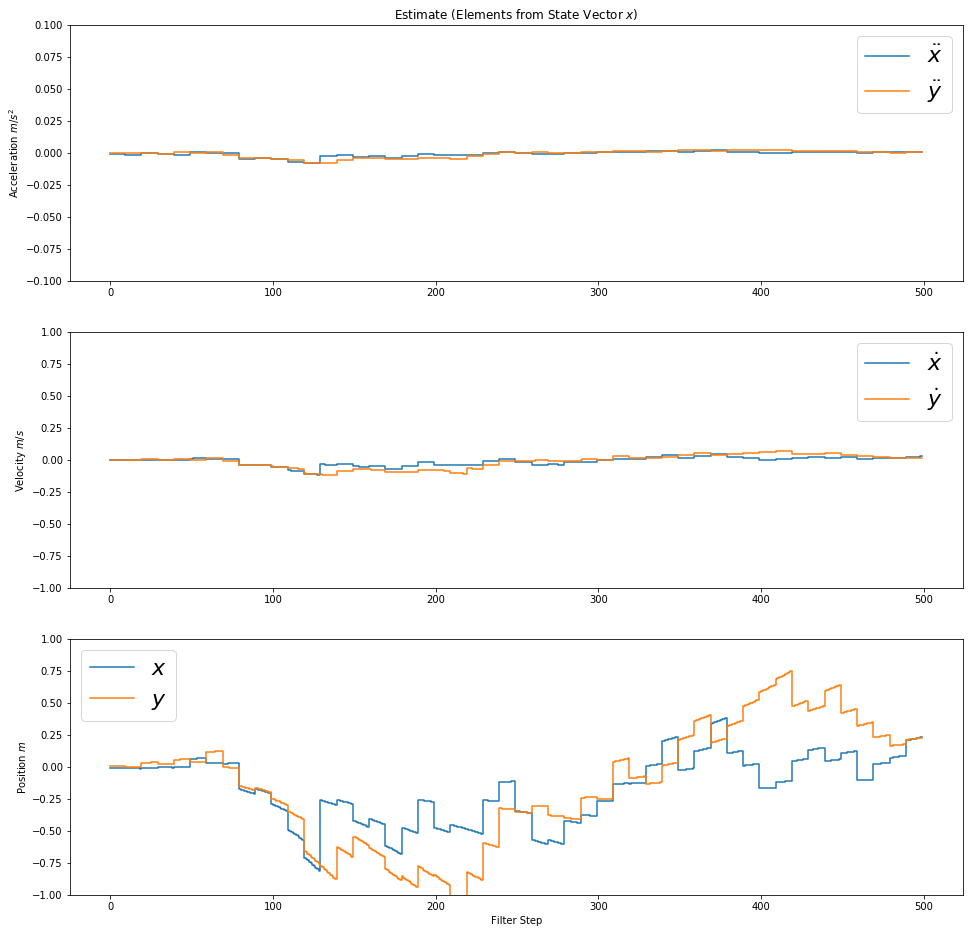

In [34]:
plot_x()

## Position x/y

In [35]:
def plot_xy():

    fig = plt.figure(figsize=(16,16))
    plt.plot(xt,yt, label='State',alpha=0.5)
    plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Position')
    plt.legend(loc='best')
    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    plt.savefig('Kalman-Filter-CA-Position.png', dpi=72, transparent=True, bbox_inches='tight')

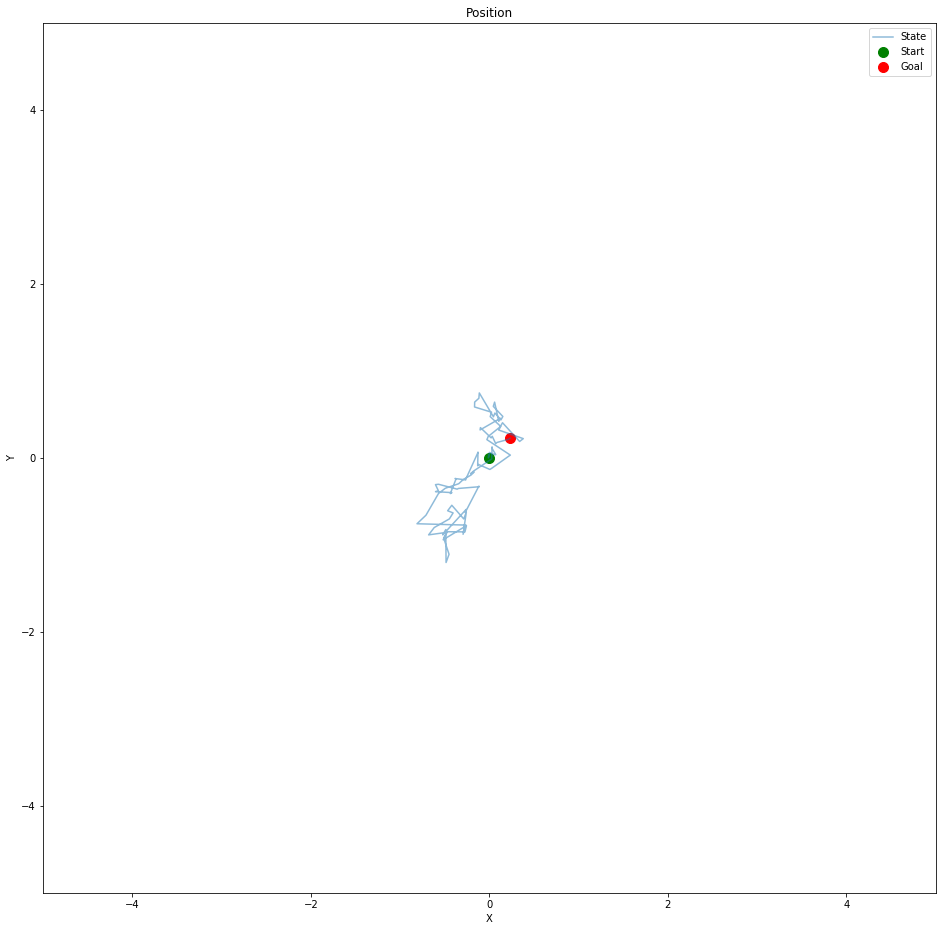

In [36]:
plot_xy()

# Conclusion

![Nice](http://www.troll.me/images/stifler-thumbs-up/nice.jpg)

It works pretty well.

As you can see, good idea to measure the position as well as the acceleration to try to estimate the position.

In [37]:
dist=np.cumsum(np.sqrt(np.diff(xt)**2 + np.diff(yt)**2))
print('Your drifted %dm from origin.' % dist[-1])

Your drifted 11m from origin.


To use this notebook as a presentation type:

`jupyter-nbconvert --to slides Kalman-Filter-CA-2.ipynb --reveal-prefix=reveal.js --post serve` 

Questions? [@Balzer82](https://twitter.com/balzer82)